## Mixture Density Networks (Gaussian Mixture) for inverted sinusoidal function

### 0. Global seeding

In [5]:
import lagom
import lagom.utils as utils
lagom.set_global_seeds(seed=0)

### 1. Data generation

In [2]:
import numpy as np

import torch
from torch.utils import data


class Dataset(data.Dataset):
    r"""Generate a set of data point of an inverted sinusoidal function. 
    i.e. y(x) = 7sin(0.75x) + 0.5x + eps, eps~N(0, 1)
    
    Then we ask the neural networks to predict x given y, in __getitem__(). 
    In this case, the classic NN suffers due to only one output given input. 
    To address it, one can use Mixture Density Networks. 
    """
    def __init__(self, n):
        self.n = n
        self.x, self.y = self._generate_data(self.n)
    
    def _generate_data(self, n):
        eps = np.random.randn(n)
        x = np.random.uniform(low=-10.5, high=10.5, size=n)
        y = 7*np.sin(0.75*x) + 0.5*x + eps
        
        return np.float32(x), np.float32(y)  # Enforce the dtype to be float32, i.e. FloatTensor in PyTorch
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        # Retrieve the x, y value
        x = self.x[index]
        y = self.y[index]
        # Keep array shape due to scalar value
        x = np.array([x], dtype=np.float32)
        y = np.array([y], dtype=np.float32)

        return y, x

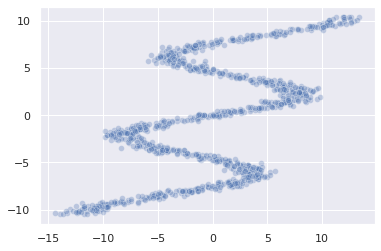

In [4]:
import seaborn as sns
sns.set()

dataset = Dataset(n=1000)
sns.scatterplot(dataset.y, dataset.x, alpha=0.3)

### 2. Make MDN network

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class MDN(lagom.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_density, **kwargs):
        super().__init__(**kwargs)
        
        self.hidden_sizes = hidden_sizes
        self.feature_layers = lagom.nn.make_fc(input_size, hidden_sizes)
        for layer in self.feature_layers:
            lagom.nn.ortho_init(layer, nonlinearity='relu', constant_bias=0.0)
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_size) for hidden_size in hidden_sizes])
        self.mdn_head = lagom.nn.MDNHead(hidden_sizes[-1], output_size, num_density)

    def forward(self, x):
        for layer, layer_norm in zip(self.feature_layers, self.layer_norms):
            x = layer_norm(F.relu(layer(x)))
        return self.mdn_head(x)


device = torch.device('cpu')
model = MDN(input_size=1, hidden_sizes=[15, 15], output_size=1, num_density=20).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
model

MDN(
  (feature_layers): ModuleList(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
  )
  (layer_norms): ModuleList(
    (0): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  )
  (mdn_head): MDNHead(
    (pi_head): Linear(in_features=15, out_features=20, bias=True)
    (mean_head): Linear(in_features=15, out_features=20, bias=True)
    (logvar_head): Linear(in_features=15, out_features=20, bias=True)
  )
)

### 2. Training

In [7]:
N = 3000
epochs = 1000
batch_size = 128

dataset = Dataset(n=N)
dataloader = data.DataLoader(dataset, batch_size=batch_size)
model.train()
for epoch in range(epochs):
    losses = []
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        logit_pi, mean, std = model(x)
        loss = model.mdn_head.loss(logit_pi, mean, std, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    if epoch == 0 or (epoch+1)%100 == 0:
        print(f'Epoch: {epoch+1}\t Loss: {np.mean(losses)}')

Epoch: 1	 Loss: 9.803922692934671
Epoch: 100	 Loss: 1.4200397183497746
Epoch: 200	 Loss: 1.4081105838219325
Epoch: 300	 Loss: 1.4095855504274368
Epoch: 400	 Loss: 1.4060412396987279
Epoch: 500	 Loss: 1.4243323157231014
Epoch: 600	 Loss: 1.4070613980293274
Epoch: 700	 Loss: 1.4061066160599391
Epoch: 800	 Loss: 1.4005842457214992
Epoch: 900	 Loss: 1.3634643057982128
Epoch: 1000	 Loss: 1.357205832997958


### 3. Evaluation

In [8]:
torch.linspace(-15, 15, steps=10)

tensor([-15.0000, -11.6667,  -8.3333,  -5.0000,  -1.6667,   1.6667,   5.0000,
          8.3333,  11.6667,  15.0000])

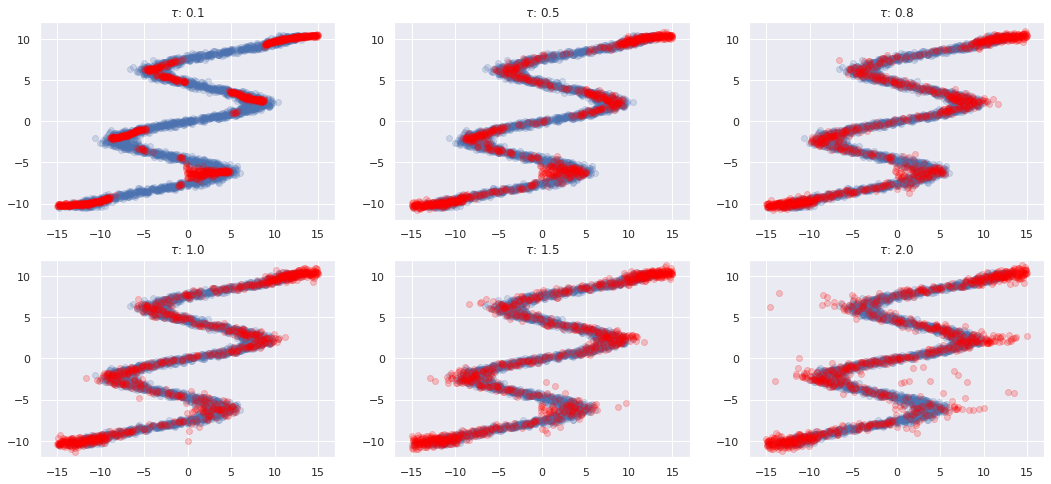

In [10]:
import matplotlib.pyplot as plt
sns.set()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6*3, 4*2))

# Temperature: controls the uncertainty. Larger temperature leads to larger uncertainty. 
list_tau = [0.1, 0.5, 0.8, 1.0, 1.5, 2.0]

test_data = torch.linspace(-15, 15, steps=1000).unsqueeze(1)

with torch.no_grad():
    model.eval()
    
    logit_pi, mean, std = model(test_data.to(device))
    for tau, ax in zip(list_tau, axes.reshape(-1)):
        samples = model.mdn_head.sample(logit_pi, mean, std, tau)

        ax.scatter(dataset.y, dataset.x, alpha=0.2)
        ax.scatter(utils.numpify(test_data, np.float32), utils.numpify(samples, np.float32), alpha=0.2, color='red')

        offset = 2
        ax.set_xlim(-15 - offset, 15 + offset)
        ax.set_ylim(-10 - offset, 10 + offset)
        
        ax.set_title(r'$\tau$: ' + str(tau))
    
#fig.savefig('samples.png')